# Task 3: Zero Noise Extrapolation error mitigation method
## Problem Statement in the QOSF form

In this task, one will build a simple ZNE function from scratch:

1. Build a simple noise model with depolarizing noise 
2. Create different circuits to test your noise models and choose the observable to measure 
3. Apply the unitary folding method. 
4. Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
5. Compare mitigated and unmitigated results 
6. Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service


## References 

[1] [Review of ZNE and improvements](https://arxiv.org/abs/2005.10921)

[2] [Mitiq](https://mitiq.readthedocs.io/en/stable/guide/zne-5-theory.html)

[3] [Original ZNE paper](https://arxiv.org/abs/1611.09301) 




## Motivation
In the current NISQ area, noise is quite a significant problem and Fault Tolerant Quantum Computers (FTQ) are quite far-fetched. Hence it is best to try to make the best of the NISQ era and try to mitigate the noise in order to possibly apply VQAs in order to possibly have the quantum advantage to some real-world application. Fundamentally these methods allow us to have better estimates of expectation values, not correct measurements. Plus it is quite fun to learn and apply these algorithms. One of the error mitigation methods is ZNE.  

## Basic idea and method
ZNE's name itself tells us a lot about the methodology given that we have some prior context. ZNE is a methodology to essentially parameterize the noise levels in order to obtain the zero noise case through extrapolation using no additional quantum resources. Essential idea from what I have understood, generally ZNE's methodology for some expectation value $E$ is as following:
1. Obtain the Expectation data for different noise levels $E(\lambda)$
2. Find an appropriate extrapolating method
3. Obtain 
$$\lim_{n\to 0^+} E(n)$$

### Expectation data with different noise levels
Firstly, we will look at just artificially increasing the noise levels by increasing the gates' error probabilities. The error probabilities of gates are taken as the following:
1. $10^{-3}$ for single qubit gates
2. $10^{-2}$ for two qubit gates

Note: *This values can be changed by just providing error values as input in the depolarizing_initiaition function.*

Secondly, we will then look at unitary folding method, for two reasons (according to reference [1]):
1. Ease of programmer level access
2. No recalibration of Control pulses is required

### Extrapolation methods
We will look at the following extrapolation methods
1. Linear
2. Quadratic
3. N-degree polynomial (N=5)
4. Exponential: $c + a * e^\left(-b * x \right)$
5. Power: $a + b* p ^{-x}$

## Importing the necessary libraries

In [1]:
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
from scipy.optimize import minimize, curve_fit

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import InverseModifier
from qiskit_ibm_runtime import QiskitRuntimeService, Session
# from qiskit_ibm_runtime import IBMQ
# from qiskit import  IBMQ
from qiskit_aer import noise
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
#import copy for copying the qiskit circuit
import copy
from utils import DepolarizingNoiseModel, exp_func, power_func, QuantumCircuit_Generator, apply_folding_method

from qiskit_ibm_provider import IBMProvider

from matplotlib import pyplot as plt

In [2]:
# token = "689a1502357abdfac788a5354a6fe0bfac3ef9886ae66f124fce0748379557334fff4b2b1bd6467ba785eee86d54302af9808e14c3b16293b7f034eb8d5f4b17"
# IBMProvider.save_account(token=token)

## Building the noise model
Importing the Class from utils.py having a simple noise model with depolarizing noise. Please look at utils.py for it's implementation. I have not put it here for convenience and readibility.

### Creating a Quantum Circuit using qiskit with integrated gate-wise unitary folding
This is determined by giving the `m_value`, which is by default 0. The `m_value` parameter indicates how much of the circuit is to be folded, `m_value` $\in [0, \infty)$. Since `m_value` can take fractional value, this framework implements both circuit folding and gate folding method.

In [3]:
Layers = 2

num_qubits = 2

m_value = 1.5
params = 4* np.pi*np.random.rand(Layers, num_qubits)

test_circuit = QuantumCircuit_Generator(Layers, num_qubits, params, m_value=m_value)

test_circuit.draw()

┌───────────┐      ┌────────────┐      ░  ┌────────────┐  ┌───────────┐ »
q_0: ─┤ Rz(3.989) ├───■──┤ Rz(5.8154) ├──■───░──┤ Rz(-3.989) ├──┤ Rz(3.989) ├─»
     ┌┴───────────┴┐┌─┴─┐├────────────┤┌─┴─┐ ░ ┌┴────────────┴┐┌┴───────────┴┐»
q_1: ┤ Rz(0.18921) ├┤ X ├┤ Rz(8.6454) ├┤ X ├─░─┤ Rz(-0.18921) ├┤ Rz(0.18921) ├»
     └─────────────┘└───┘└────────────┘└───┘ ░ └──────────────┘└─────────────┘»
«               ┌─────────────┐┌────────────┐           ░  ┌───────────┐ »
«q_0: ──■────■──┤ Rz(-5.8154) ├┤ Rz(5.8154) ├──■────■───░──┤ Rz(3.989) ├─»
«     ┌─┴─┐┌─┴─┐├─────────────┤├────────────┤┌─┴─┐┌─┴─┐ ░ ┌┴───────────┴┐»
«q_1: ┤ X ├┤ X ├┤ Rz(-8.6454) ├┤ Rz(8.6454) ├┤ X ├┤ X ├─░─┤ Rz(0.18921) ├»
«     └───┘└───┘└─────────────┘└────────────┘└───┘└───┘ ░ └─────────────┘»
«      ┌────────────┐ ┌────────────┐┌───────────┐
«q_0: ─┤ Rz(-3.989) ├─┤ Rz(-3.989) ├┤ Rz(3.989) ├
«     ┌┴────────────┴┐└────────────┘└───────────┘
«q_1: ┤ Rz(-0.18921) ├───────────────────────────
«     └──────────────┘

#### First doing with artificially increasing gate error rates

In [4]:
Layers = 10

num_qubits = 2

m_value = 0
params = 4* np.pi*np.random.rand(Layers, num_qubits)

circuit = QuantumCircuit_Generator(Layers, num_qubits, params, m_value=m_value)


In [5]:
noise_levels = [1,2,5,10,20,50,100]
circuit =circuit
value_to_extrapolate = '00'
DNModel = DepolarizingNoiseModel(noise_levels, circuit, value_to_extrapolate)

In [7]:
DNModel.get_noise_level_data(shots=1024)
DNModel.all_data

[{'01': 0.02734375, '10': 0.0234375, '00': 0.931640625, '11': 0.017578125},
 {'10': 0.048828125, '00': 0.8515625, '01': 0.041015625, '11': 0.05859375},
 {'11': 0.103515625,
  '01': 0.111328125,
  '00': 0.6767578125,
  '10': 0.1083984375},
 {'11': 0.1689453125, '01': 0.1845703125, '10': 0.177734375, '00': 0.46875},
 {'01': 0.234375, '10': 0.2265625, '00': 0.3193359375, '11': 0.2197265625},
 {'01': 0.240234375, '00': 0.263671875, '10': 0.255859375, '11': 0.240234375},
 {'00': 0.2353515625,
  '10': 0.259765625,
  '11': 0.251953125,
  '01': 0.2529296875}]

In [8]:
DNModel.ZNE()

In [9]:
def obtain_fun():
    func = []
    for i in range(len(DNModel.ZNE_functions)):
        func.append(DNModel.ZNE_functions[i])
    return func

func = obtain_fun()

In [10]:
popt = func[3][0]
popt_1 = func[4][0]
popt,popt_1

(array([0.77200534, 0.12172768, 0.24862304]),
 array([ 2.62692647e+03, -2.62623361e+03,  9.99997766e-01]))

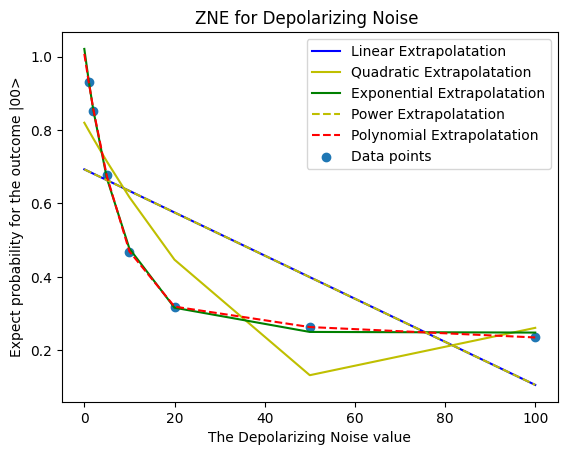

In [11]:
extrapolate_plot = np.array([0] + (noise_levels))

plt.plot(extrapolate_plot, [func[0](iter) for iter in extrapolate_plot], 'b' , label="Linear Extrapolatation")
plt.plot(extrapolate_plot,[func[1](iter) for iter in extrapolate_plot], 'y', label="Quadratic Extrapolatation")
plt.plot(extrapolate_plot, exp_func(extrapolate_plot, *popt), 'g', label="Exponential Extrapolatation")
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1), 'y--', label="Power Extrapolatation")
plt.plot(extrapolate_plot,[func[2](iter) for iter in extrapolate_plot], 'r--', label="Polynomial Extrapolatation")
plt.scatter(noise_levels, DNModel.results_data, label="Data points")
plt.title('ZNE for Depolarizing Noise ')
plt.ylabel(f'Expect probability for the outcome |{value_to_extrapolate}>')
plt.xlabel('The Depolarizing Noise value')
plt.legend()
plt.show()

#### Note that scipy's curve_fit sometimes fails and gives very bad result
See the below plot

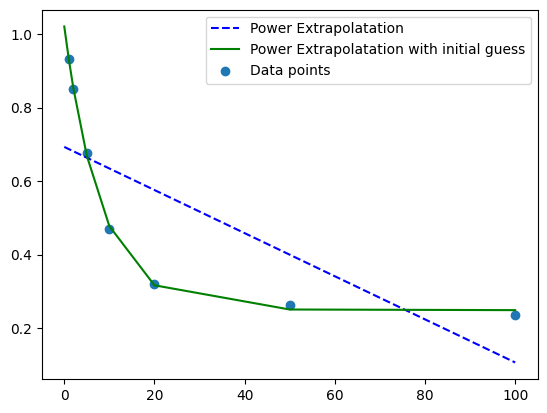

In [12]:
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1), 'b--', label="Power Extrapolatation")
params = 4* np.pi*np.random.rand(Layers, num_qubits)
# this can be made better by providing intiial guess
DNModel.ZNE(p0_power=[1,1,2])
popt_1_init = DNModel.ZNE_functions[4][0]
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1_init), 'g', label="Power Extrapolatation with initial guess")
plt.scatter(noise_levels, DNModel.results_data, label="Data points")
plt.legend()

### Re-running with a different circuit and value to extrapolate to be $|1111>$

In [13]:
num_qubits = 4
Layers=15
params = 4* np.pi*np.random.rand(Layers, num_qubits)
circuit = QuantumCircuit_Generator(Layers, num_qubits, params, N_1_flag=True)
circuit.draw()

┌────────────┐     ┌────────────┐                             »
q_0: ┤ Rz(10.124) ├──■──┤ Rz(3.1901) ├─────────────────────■───────»
     ├────────────┤┌─┴─┐└────────────┘┌─────────────┐    ┌─┴─┐     »
q_1: ┤ Rz(4.5305) ├┤ X ├──────■───────┤ Rz(0.28601) ├────┤ X ├─────»
     ├────────────┤└───┘    ┌─┴─┐     └─────────────┘┌───┴───┴────┐»
q_2: ┤ Rz(5.6813) ├─────────┤ X ├────────────■───────┤ Rz(1.2364) ├»
     ├────────────┤         └───┘          ┌─┴─┐     ├────────────┤»
q_3: ┤ Rz(12.302) ├────────────────────────┤ X ├─────┤ Rz(3.1604) ├»
     └────────────┘                        └───┘     └────────────┘»
«     ┌────────────┐                            ┌────────────┐              »
«q_0: ┤ Rz(2.0935) ├────────────────────■───────┤ Rz(9.3516) ├──────────────»
«     └────────────┘┌────────────┐    ┌─┴─┐     └────────────┘┌────────────┐»
«q_1: ──────■───────┤ Rz(5.1393) ├────┤ X ├───────────■───────┤ Rz(6.5908) ├»
«         ┌─┴─┐     └────────────┘┌───┴───┴────┐    ┌─┴─┐     └────────────┘»
«q_2: ────┤ X ├───────────■───────┤ Rz(3.1086) ├────┤ X ├───────────■───────»
«         └───┘         ┌─┴─┐     ├────────────┤    └───┘         ┌─┴─┐     »
«q_3: ──────────────────┤ X ├─────┤ Rz(1.6658) ├──────────────────┤ X ├─────»
«                       └───┘     └────────────┘                  └───┘     »
«                   ┌────────────┐                             ┌────────────┐»
«q_0: ──────■───────┤ Rz(2.0966) ├─────────────────────■───────┤ Rz(11.712) ├»
«         ┌─┴─┐     └────────────┘┌────────────┐     ┌─┴─┐     └────────────┘»
«q_1: ────┤ X ├───────────■───────┤ Rz(9.9288) ├─────┤ X ├───────────■───────»
«     ┌───┴───┴────┐    ┌─┴─┐     └────────────┘ ┌───┴───┴───┐     ┌─┴─┐     »
«q_2: ┤ Rz(7.9985) ├────┤ X ├───────────■────────┤ Rz(4.708) ├─────┤ X ├─────»
«     ├────────────┤    └───┘         ┌─┴─┐     ┌┴───────────┴┐    └───┘     »
«q_3: ┤ Rz(10.784) ├──────────────────┤ X ├─────┤ Rz(0.33916) ├──────────────»
«     └────────────┘                  └───┘     └─────────────┘              »
«                                 ┌────────────┐                            »
«q_0: ────────────────────■───────┤ Rz(12.398) ├────────────────────■───────»
«     ┌────────────┐    ┌─┴─┐     └────────────┘┌────────────┐    ┌─┴─┐     »
«q_1: ┤ Rz(1.7895) ├────┤ X ├───────────■───────┤ Rz(8.0576) ├────┤ X ├─────»
«     └────────────┘┌───┴───┴────┐    ┌─┴─┐     └────────────┘┌───┴───┴────┐»
«q_2: ──────■───────┤ Rz(12.545) ├────┤ X ├───────────■───────┤ Rz(6.6262) ├»
«         ┌─┴─┐     ├────────────┤    └───┘         ┌─┴─┐     ├────────────┤»
«q_3: ────┤ X ├─────┤ Rz(3.6944) ├──────────────────┤ X ├─────┤ Rz(4.8221) ├»
«         └───┘     └────────────┘                  └───┘     └────────────┘»
«     ┌────────────┐                            ┌────────────┐              »
«q_0: ┤ Rz(11.287) ├────────────────────■───────┤ Rz(11.726) ├──────────────»
«     └────────────┘┌────────────┐    ┌─┴─┐     └────────────┘┌────────────┐»
«q_1: ──────■───────┤ Rz(10.382) ├────┤ X ├───────────■───────┤ Rz(1.0347) ├»
«         ┌─┴─┐     └────────────┘┌───┴───┴────┐    ┌─┴─┐     └────────────┘»
«q_2: ────┤ X ├───────────■───────┤ Rz(8.1711) ├────┤ X ├───────────■───────»
«         └───┘         ┌─┴─┐     ├────────────┤    └───┘         ┌─┴─┐     »
«q_3: ──────────────────┤ X ├─────┤ Rz(11.238) ├──────────────────┤ X ├─────»
«                       └───┘     └────────────┘                  └───┘     »
«                   ┌───────────┐                            ┌────────────┐»
«q_0: ──────■───────┤ Rz(11.49) ├────────────────────■───────┤ Rz(10.736) ├»
«         ┌─┴─┐     └───────────┘┌────────────┐    ┌─┴─┐     └────────────┘»
«q_1: ────┤ X ├───────────■──────┤ Rz(2.8808) ├────┤ X ├───────────■───────»
«     ┌───┴───┴────┐    ┌─┴─┐    └────────────┘┌───┴───┴────┐    ┌─┴─┐     »
«q_2: ┤ Rz(12.006) ├────┤ X ├──────────■───────┤ Rz(11.945) ├────┤ X ├─────»
«     ├────────────┤    └───┘        ┌─┴─┐     ├───────────┬┘    └───┘     »
«q_3: ┤ Rz(6.6303) ├────────

In [15]:
value_to_extrapolate = '1111'
DNModel = DepolarizingNoiseModel(noise_levels, circuit, value_to_extrapolate)
DNModel.get_noise_level_data(shots=1024)
DNModel.ZNE(p0_power=[1,1,2])
# displaying the first two iterations' results
DNModel.all_data[0:2]

[{'1000': 0.001953125,
  '0110': 0.001953125,
  '0100': 0.001953125,
  '1110': 0.01171875,
  '0010': 0.0048828125,
  '0101': 0.0205078125,
  '1100': 0.0166015625,
  '1101': 0.01953125,
  '0001': 0.033203125,
  '1010': 0.0205078125,
  '1111': 0.6884765625,
  '1011': 0.041015625,
  '0011': 0.048828125,
  '0111': 0.0400390625,
  '0000': 0.0234375,
  '1001': 0.025390625},
 {'0010': 0.009765625,
  '1000': 0.013671875,
  '1110': 0.0205078125,
  '0110': 0.0146484375,
  '0100': 0.0048828125,
  '1001': 0.0419921875,
  '1011': 0.0556640625,
  '0001': 0.0556640625,
  '1100': 0.0224609375,
  '0101': 0.0439453125,
  '1111': 0.4853515625,
  '1010': 0.025390625,
  '0000': 0.021484375,
  '0011': 0.0634765625,
  '0111': 0.0693359375,
  '1101': 0.0517578125}]

In [16]:
DNModel.ZNE()
func = obtain_fun()
popt = func[3][0]
popt_1 = func[4][0]
popt_1

array([0.06350694, 0.9043565 , 1.45525106])

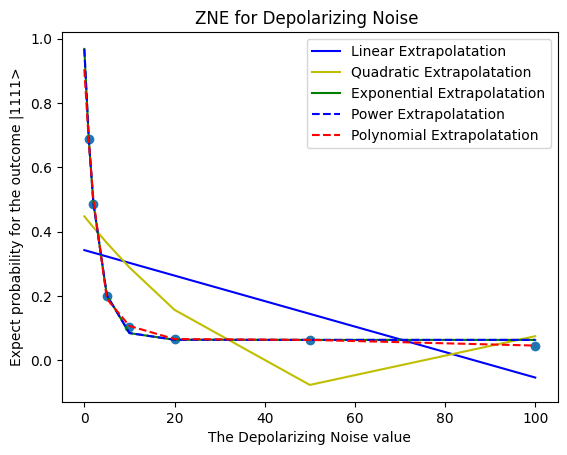

In [17]:
extrapolate_plot = np.array([0] + (noise_levels))

plt.plot(extrapolate_plot, [func[0](iter) for iter in extrapolate_plot], 'b' , label="Linear Extrapolatation")
plt.plot(extrapolate_plot,[func[1](iter) for iter in extrapolate_plot], 'y', label="Quadratic Extrapolatation")
plt.plot(extrapolate_plot, exp_func(extrapolate_plot, *popt), 'g', label="Exponential Extrapolatation")
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1), 'b--', label="Power Extrapolatation")
plt.plot(extrapolate_plot,[func[2](iter) for iter in extrapolate_plot], 'r--', label="Polynomial Extrapolatation")
plt.scatter(noise_levels, DNModel.results_data)
plt.title('ZNE for Depolarizing Noise ')
plt.ylabel(f'Expect probability for the outcome |{value_to_extrapolate}>')
plt.xlabel('The Depolarizing Noise value')
plt.legend()
plt.show()

#### It can be seen that all the last three extrapolation methods perform quite well, but now let's try testing it with unitary folding method and on a Quantum Computer

## Unitary Folding method
Based on reference [1].
### Description
The unitary folding method in a sense is de-optimizing the circuit, opposite to what a quantum compiler would do. It increases the total number of gates from initial depth (or number of layers) $d$ to $d \to \lambda d$ based on the scaling factor $\lambda$, in order to obtain the necessary data for extrapolation.

### $\lambda$'s Formula
$$ \lambda = 1 + \frac{2k}{d}, k=1,2,3,\dots $$

For odd positive $\lambda=1+2n$, we get an exponential parameterization of noise level $p$.

### Folding rule
$$ A \to A(A^{\dagger}A) $$

If A is the entire circuit then it is the **Circuit folding** method and if the A is a Gate or Layer then it is the **Gate or Layer folding** method.

### General rule
$$ U \to U(U^{\dagger} U)L^{\dagger}_d, L^{\dagger}_{d-1}, \dots,  L_s L_s, \dots, L_{d-1}, L_d , U=L_d, \dots, L_2, L_1 $$

### Limitations
1. Not appropriate to amplify systematic and coherent errors.
2. It can not amplify state preparation and measurement noise (SPAM).

### Usage
We will use the general rule with 'From Left' method. Though this method has an impressive resolution of $\frac{2}{d}$. For our practical use-case, we'll have a resolution of 0.5 Hence our depth scaling will be as follow: $d, d+0.5, \dots, d+m*d$

#### Though the circuit Please note that the circuit has some specific format, though the unitary folding function `apply_unitary_folding`, is made quite general and can be easily adapted to any circuit of choice. 
For instance, this method also works on the `EfficientSU2` circuit

In [20]:
test_circ = EfficientSU2(num_qubits=2,reps=1).decompose()
test_circ.barrier()
circuit = apply_folding_method(test_circ, m_value=2)
circuit.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐ ░ ┌───────────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─░─┤ Ry(-1.0*θ[0]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤ ░ ├───────────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─░─┤ Ry(-1.0*θ[1]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘ ░ └───────────────┘»
«     ┌──────────┐┌───────────────┐┌──────────┐          ┌───────────────┐»
«q_0: ┤ Ry(θ[0]) ├┤ Rz(-1.0*θ[2]) ├┤ Rz(θ[2]) ├──■────■──┤ Ry(-1.0*θ[4]) ├»
«     ├──────────┤├───────────────┤├──────────┤┌─┴─┐┌─┴─┐├───────────────┤»
«q_1: ┤ Ry(θ[1]) ├┤ Rz(-1.0*θ[3]) ├┤ Rz(θ[3]) ├┤ X ├┤ X ├┤ Ry(-1.0*θ[5]) ├»
«     └──────────┘└───────────────┘└──────────┘└───┘└───┘└───────────────┘»
«     ┌──────────┐┌───────────────┐┌──────────┐ ░ ┌──────────────┐»
«q_0: ┤ Ry(θ[4]) ├┤ Rz(-1.0*θ[6]) ├┤ Rz(θ[6]) ├─░─┤ Ry(1.0*θ[0]) ├»
«     ├──────────┤├───────────────┤├──────────┤ ░ ├──────────────┤»
«q_1: ┤ Ry(θ[5]) ├┤ Rz(-1.0*θ[7]) ├┤ Rz(θ[7]) ├─░─┤ Ry(1.0*θ[1]) ├»
«     └──────────┘└───────────────┘└──────────┘ ░ └──────────────┘»
«     ┌───────────────┐┌───────────────┐┌──────────┐┌──────────────┐»
«q_0: ┤ Ry(-1.0*θ[0]) ├┤ Ry(-1.0*θ[0]) ├┤ Ry(θ[0]) ├┤ Rz(1.0*θ[2]) ├»
«     ├───────────────┤├───────────────┤├──────────┤├──────────────┤»
«q_1: ┤ Ry(-1.0*θ[1]) ├┤ Ry(-1.0*θ[1]) ├┤ Ry(θ[1]) ├┤ Rz(1.0*θ[3]) ├»
«     └───────────────┘└───────────────┘└──────────┘└──────────────┘»
«     ┌───────────────┐┌───────────────┐┌──────────┐                    
«q_0: ┤ Rz(-1.0*θ[2]) ├┤ Rz(-1.0*θ[2]) ├┤ Rz(θ[2]) ├──■────■────■────■──
«     ├───────────────┤├───────────────┤├──────────┤┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
«q_1: ┤ Rz(-1.0*θ[3]) ├┤ Rz(-1.0*θ[3]) ├┤ Rz(θ[3]) ├┤ X ├┤ X ├┤ X ├┤ X ├
«     └───────────────┘└───────────────┘└──────────┘└───┘└───┘└───┘└───┘

#### Testing Unitary fold method on a simulator

In [21]:
num_qubits = 3
Layers=12
params = 4* np.pi*np.random.rand(Layers, num_qubits)
circuit = QuantumCircuit_Generator(Layers, num_qubits, params)

In [31]:
value_to_extrapolate = '000'
# here noise_levels are m_values
noise_levels = [0.5*(i) for i in range(1,12)]
DNModel = DepolarizingNoiseModel(noise_levels, circuit, value_to_extrapolate, unitary_fold=True)
DNModel.get_noise_level_data(shots=1024)
# displaying the first two iterations' results
DNModel.all_data[0:2]
DNModel.ZNE()

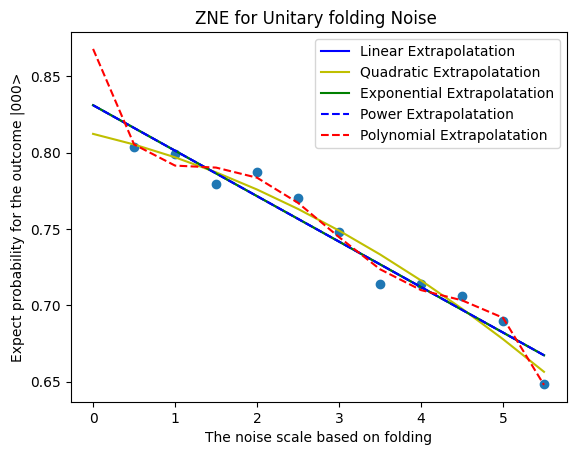

In [34]:
func = obtain_fun()
popt = func[3][0]
popt_1 = func[4][0]

extrapolate_plot = np.array([0] + (noise_levels))

plt.plot(extrapolate_plot, [func[0](iter) for iter in extrapolate_plot], 'b' , label="Linear Extrapolatation")
plt.plot(extrapolate_plot,[func[1](iter) for iter in extrapolate_plot], 'y', label="Quadratic Extrapolatation")
plt.plot(extrapolate_plot, exp_func(extrapolate_plot, *popt), 'g', label="Exponential Extrapolatation")
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1), 'b--', label="Power Extrapolatation")
plt.plot(extrapolate_plot,[func[2](iter) for iter in extrapolate_plot], 'r--', label="Polynomial Extrapolatation")
plt.scatter(noise_levels, DNModel.results_data)
plt.title('ZNE for Unitary folding Noise ')
plt.ylabel(f'Expect probability for the outcome |{value_to_extrapolate}>')
plt.xlabel('The noise scale based on folding')
plt.legend()
plt.show()

### Running it on a real quantum computer

In [35]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
# service.backends()
ibmq_backend = service.backend("ibm_osaka")

In [36]:
num_qubits = 2
Layers=5
params = 4* np.pi*np.random.rand(Layers, num_qubits)
circuit = QuantumCircuit_Generator(Layers, num_qubits, params)

#### I waited hours but obtained no results, partly because of the large waiting time. But if given access this would work in principle.

In [ ]:
value_to_extrapolate = '00'
# here noise_levels are m_values
noise_levels = [0.5*(i) for i in range(1, 6)]
DNModel = DepolarizingNoiseModel(noise_levels, circuit, value_to_extrapolate, unitary_fold=True)
DNModel.get_noise_level_data(shots=1024, qiskit_backend=ibmq_backend)
# displaying the first two iterations' results
DNModel.all_data[0:2]
DNModel.ZNE()

In [ ]:
func = obtain_fun()
popt = func[3][0]
popt_1 = func[4][0]

extrapolate_plot = np.array([0] + (noise_levels))

plt.plot(extrapolate_plot, [func[0](iter) for iter in extrapolate_plot], 'b' , label="Linear Extrapolatation")
plt.plot(extrapolate_plot,[func[1](iter) for iter in extrapolate_plot], 'y', label="Quadratic Extrapolatation")
plt.plot(extrapolate_plot, exp_func(extrapolate_plot, *popt), 'g', label="Exponential Extrapolatation")
plt.plot(extrapolate_plot, power_func(extrapolate_plot, *popt_1), 'b--', label="Power Extrapolatation")
plt.plot(extrapolate_plot,[func[2](iter) for iter in extrapolate_plot], 'r--', label="Polynomial Extrapolatation")
plt.scatter(noise_levels, DNModel.results_data)
plt.title('ZNE for Unitary folding Noise on IBM Osaka')
plt.ylabel(f'Expect probability for the outcome |{value_to_extrapolate}>')
plt.xlabel('The noise scale based on folding')
plt.legend()
plt.show()

#### Future Improvements
[1] [Adaptive Shots strategy (3-stage approach)](https://arxiv.org/abs/1912.06007)

[2] [Smart Measurement allocation policy](https://iopscience.iop.org/article/10.1088/1367-2630/aab919) 

[3] [Interpolating algorithm (Alpha-VQE)](https://arxiv.org/abs/2005.10921)

[4] [Parallelization of ZNE](https://arxiv.org/pdf/2112.00387.pdf#cite.li2017efficient)